
$$\newcommand{\vec}[1]{{\bf #1} } 
\newcommand{\real}{\mathbb{R} }
\newcommand{\expect}[1]{\mathbb{E}[#1] }
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\argmax}{arg\,max}
\newcommand{\E}{\mathbb{E}}$$

## ELEC-E7851: Computational User Interface Design (Fall 2021) 

# Lecture 2: Introduction to Computational Design

## Antti Oulasvirta, Aalto University

**Overview**: This notebook introduces basic theory and concepts of computational design. A menu system is used as a running example throught. In practice, we will generate a menu system with combinatorial optimization using 
* a hand-crafted (heuristic) objective function
* a learned (data-driven) objective function
* a theory-based model as the objective function.
We will return to many of these concepts and methods throughout the course.

_Acknowledgements_: Tayyaba Taimur (word2vec application; utilities.py)

---
### Elements of a computational design system
<img src="images/overview2.pdf" width="96%" title="Overview" />

### Introducing our Case: A menu system

Throughout the notebook, we will be using interactive menu system as our example.

Try it out!
* Launch the menu
* Click on its items, simulating what a user might do. Press "Stop" when done
* Click data are stored in data.csv
* The structure of the menu is expressed as a list where '-' means a group separator 
* If the menu variable is changed, the changes will be visible when the menu is opened again.

In [1]:
import utilities
from collections import Counter

menu = ["help", "-", "open","save","-","print","close","-","about"]

# Shows the menu

utilities.showmenu(menu)

Output()

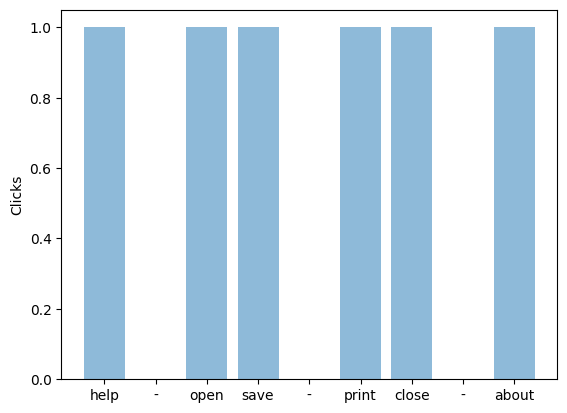

In [2]:
# Plots click data

frequencies = utilities.parsedata()
utilities.plothistogram(menu)


---

# 1. Generating Designs with Combinatorial Optimization

In **generative design**, the problem is to generate an interface that optimizers for stated objectives while obeying given constraints. 

Naive approaches to this problem include:
* Template-based: Formulate a distance metric to pick a template that best matches with the given elements. 
* Rule-based: Apply a hand-coded system of rules, such as 'always place a heading element to the top'.

<div class="alert alert-block alert-success">
<b>Discussion:</b> These approaches scale poorly. Why?
</div>

## Combinatorial optimization
**Combinatorial optimization** refers to the combination of discrete design decisions to obtain an optimal solution defined by a stated objective function. In particular, the task is to find the design that yields the highest value of a given objective (goodness) function $f$:
$$\mbox{Find } \mathbf{x} =
	\begin{pmatrix}
	x_1 \\
	x_2 \\
	\vdots \\
	x_n
	\end{pmatrix} \in \mathbf{X}
\mbox{ which maximizes } f(\mathbf{x})$$
where 
* $\mathbf{x}$ is an *n*-dimensional **design vector**,  each dimension describing a **design variable**, and
* $\mathbf{X}$ is **the set of feasible designs** (all vectors that fulfill constraints).

The objective function assigns each vector a value describing its goodness (or badness). When we optimize, we are looking for the vectors that obtain the highest value.

Combinatorial optimization methods can be divided into two main classes: (i) **Black-box methods** do not necessitate assumptions about  the objective function, but rather consider it as a black-box -- like an oracle -- that tells them the objective value of a given candidate it has generated.  (ii) **Exact methods** such as integer programming offer mathematical guarantees for solutions but insist on analysis of the objective function for revealing simplifications and links to known tasks in the optimization literature. Integer programming is covered in the other part of the day. There is exciting research going on that combines deep learning with black-box optimization.

<img src="images/optimization.png" width="75%">

### First design task

In the following, we implement a simple combinatorial optimizer that tries to generate a menu that _minimizes expected time needed for selecting commands_, given the frequency of clicks (data.csv).
* Task: Order the items such that average movement time of user is minimized 
* Task instance: The menu defined above and the click distribution
* Solver: Random search solver

> In a nutshell: In each iteration, we generate a menu randomly and evaluate it using Fitts' law that estimates average selection time. We continue like this while keeping in memory the best menu encountered so far. After exhausting computationl budget, print the best seen menu.

*Source*: Oulasvirta et al. __[Combinatorial optimization of graphical user interfaces. IEEE Proceedings (2020)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9000519)__. 

In [3]:
# Introduce Fitts' law as an objective function (obj_fitts)
# (See the description of Fitts' law in Wikipedia)
# Use a random solver to minimize average selection time of menu


import numpy as np
import math, random

def obj_fitts(menu, frequencies):
    a = 0.2 
    b = 0.3 # This coefficient controls the slope of Fitts' law
    costs = [a + b*math.log(i+1) for i in range (0, len(menu))]
    st_sum = 0.0
    # Here we compute sum weighted by click frequencies
    for i in range (0, len(menu)):
        st_sum += costs[i] * frequencies[menu[i]]
    return st_sum

# A random search -based solver
# Picks a random menu (random.sample)
def optimizer (max_iters, seed_menu, frequencies):
    bestknown_value = float('inf')
    bestknown_design = []
    for i in range (0, max_iters):
        candidate = random.sample(seed_menu, len(seed_menu))
        objective_value = obj_fitts(candidate, frequencies) 

        if objective_value < bestknown_value: # Minimization task
            bestknown_value = objective_value
            bestknown_design = candidate
    return bestknown_value, bestknown_design

bestvalue, menu = optimizer (10000, menu, frequencies)
print (bestvalue, "\n", menu)

3.1737753636030304 
 ['save', 'about', 'help', 'print', 'open', 'close', '-', '-', '-']


In [4]:
utilities.showmenu(menu)

Output()

<div class="alert alert-block alert-success">
<b>Try it out:</b> What happens if you change number of iterations? What happens if you change parameters a and b in obj_fitts?
</div>

<div class="alert alert-block alert-success">
<b>Discussion:</b> Although the elements are organized as expected, according to decreasing frequency from top to bottom, why is this **not** a good menu?
</div>

# 2. Data-driven design

In **data-driven design**, we learn a distribution of designs from a dataset and use the learned model in a generative fashion. Generated designs adhere to statistical structure learned in the dataset. 

We here learn how artificial neural networks can be used to learn a language model that can be used in the optimizer as an objective function that determines how elements should be positioned in relation to each other. Most applications of data-driven design operate with pixels or spatial representations like polygons. But don't let that fool you: the principled idea is the same as we show here.

Case: We would like to generate a menu where related items are grouped, i.e. they sit next to each other in the menu. 


### Step 1: Learning a model (word embedding)

We use methods from natural language processing (NLP) for **distributional semantics**. These methods quantify and categorize semantic similarities among linguistic items based on their distributional properties in a large corpus of language data.
<img src="images/word-embeddings.png" width="75%">

We use **Word2vec**, a word embedding -based model. Word2vec is a family of shallow, two-layer neural networks trained to reconstruct linguistic contexts of words. The input is a large corpus of text and output **a vector space**, typically of hundreds of dimensions. Each unique word in the corpus is assigned a corresponding vector in the space.

In [5]:
import os
import io
import sys
import re
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases

# dataset
TEXT_DATA_DIR = './data/20_newsgroups/'

texts = []         # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []        # list of label ids
label_text = []    # list of label texts

# Preparations
# Go through each directory
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            # News groups posts are named as numbers, with no extensions.
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                f = io.open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header in file (starts with two newlines.)
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)
                label_text.append(name)
print('Found %s texts.' % len(texts))

FileNotFoundError: [Errno 2] No such file or directory: './data/20_newsgroups/'

In [ ]:
# Cleaning data - remove punctuation from every newsgroup text
sentences = []
# Go through each text in turn
for ii in range(len(texts)):
    sentences = [re.sub(pattern=r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]', 
                        repl='', 
                        string=x
                       ).strip().split(' ') for x in texts[ii].split('\n') 
                      if not x.endswith('writes:')]
    sentences = [x for x in sentences if x != ['']]
    texts[ii] = sentences

# Compile all sentences together in one list

all_sentences = []
for text in texts:
    all_sentences += text

In [ ]:
# Create a model
model = Word2Vec(all_sentences, 
                 min_count=3,   # Ignore words that appear with fewer frequency than this
                 size=200,      # Dimensionality of word embeddings (200)
                 workers=2,     # Number of processors (parallelisation)(2)
                 window=5,      # Context window for words during training (5)
                 iter=30)       # Number of epochs training over corpus (30)

In [ ]:
# Generates a dict of associations 
def association_script(list_items):
    
    association_dict = {}
        
    for item in list_items:
        newObj={}
        for j in list_items:
            # Calculate similarity between 2 items
            similarity = model.wv.similarity(item,j)
            # If there is sufficient similarity between items, group them together
            if similarity > 0.1:
                newObj[j] = round(similarity,1);
                association_dict[item] = newObj;
            
    return association_dict
        
    
#list = ['lemon','orange', 'dog', 'horse'] 
list = menu

association_script(list)

Alternative: A manually created association matrix

In [ ]:

# We represent an association matrix here as an dict of dicts 
associations = { "open":  {"open": 1.0, "save": 0.5, "close": 0.3}, 
                 "save":  {"save": 1.0, "close": 0.2, "open": 0.5}, 
                 "close": {"close": 1.0, "open": 0.2, "save":0.2}, 
                 "help":  {"help": 1.0, "about": 0.2}, 
                 "about": {"about":1.0, "help": 0.1},
                 "print": {"print": 1.0} }

Having an association matrix allows us to revisit the objective function:

In [ ]:
# We introduce a new objective function
# It pulls associated  items together (reward) and pushes unrelated items apart (penalty)
def obj_assoc(menu, associations):
    a_sum = 0.0
    for i in range (0, len(menu)):
        if menu[i] == "-": continue

        for j in range (i+1, len(menu)):
            if menu[j] == "-": continue
            a = 0.0
            try: a = associations[menu[i]][menu[j]] * abs(i - j)
            except:
                try: a = associations[menu[j]][menu[i]] * abs(i - j)
                except: pass
            if a == 0.0 and (abs(i-j)==1):  # unrelated, should not be next to each other
                a_sum += 1.0 # penalty
            else: 
                a_sum += a
    return a_sum

def optimizer (max_iters, seed_menu, frequencies, associations):
    bestknown_value = float('inf')
    bestknown_design = []
    for i in range (0, max_iters):
        candidate = random.sample(seed_menu, len(seed_menu))
        # Association objective only
        #objective_value = obj_assoc(candidate,associations)
        # Both objectives combined in a weighted sum
        objective_value = 0.1 * obj_fitts(candidate, frequencies) + obj_assoc(candidate,associations)

        if objective_value < bestknown_value: # minimize
            bestknown_value = objective_value
            bestknown_design = candidate
    return bestknown_value, bestknown_design



bestvalue, bestdesign = optimizer (100000, menu, frequencies, associations)
print (bestvalue, bestdesign)

In [ ]:
utilities.showmenu(bestdesign)
menu = bestdesign

<div class="alert alert-block alert-success">
<b>Discussion:</b> The objective function is a weighted sum of two terms. What happens if you change the weight? 
</div>
<div class="alert alert-block alert-success">
<b>Discussion:</b> The system is **fragile**. If you change the weights, results will vary. How could this be addressed? 
</div>


---

# 3. Model-based Combinatorial Optimization

In **model-based combinatorial optimization**, we use a predictive model as an objective function.
**Predictive models** in HCI predict the consequences of some conditions on users. Numerous models exist in literature, including for motor control, perception, attention, memory, decision-making, learning, and biomechanics. 

Let us introduce a predictive model to our system! It allows us to collapse the two terms to just one. 

## Preliminary: Classical decision-making theory

**Classical decision-making theory** assumes that the decision-maker is an omniscient (all-knowing) utility-maximizing agent. The agent has multiple options and needs to select one that maximizes utility:
(based on [P. Ortega](http://www.adaptiveagents.org/freeenergy)):
$$a∗= \argmax_{a \in A}  E[U|a] \\ = \argmax_{a \in A} \sum_{x \in X} P(x|a)U(x)$$

where
* $A$ is a set of possible actions 
* $X$ is a set of possible outcomes or consequences
* $U$ is a real-valued utility function 
* $P$ is a probability distribution specifying the conditional probability P(x|a) of an outcome x given action a.

Optimal actions a* maximize expected utility. 


## Application: An optimal foraging policy for menu search

**Information foraging theory** posits that in interaction people exchange their time to obtain information. The theory originates from biology where it is used to predict animal foraging behavior. **Information foraging** refers to activities like assessing, seeking, and handling information contents in a virtual environment.  Decisions on how to pursue these are governed by (1) information allowed by available actions and (2) the time or effort needed to in each action. 

The theory propounds that interactive behavior is rational and develops to maximize the rate of information gained per unit of time (or effort) invested. In other words, in foraging, information gains are proportionate to time expended:

$$\mbox{information gained} \propto \mbox{time used}$$

We here apply this model, implemeting **a foraging policy** that describes a user's menu search strategy:
1. Look at an item
2. If it is related to the target, keep reading the present subgroup one item at a time.
3. If it is *not* related, skip to the next subgroup.
4. If the target is found, stop.
5. If the end of the  menu is reached, pay penalty.

In [ ]:
# This implements the foraging model for grouped menus

def search_time (target, menu, associations):
    t = 0.0
    groupboundary = False
    targetfound = False
    anchor = None
    
    item_cost = 0.3
    group_cost = 0.4
        
    for i in range (0, len(menu)):
        if menu[i] == "-": 
            groupboundary = True
            anchor = None
            continue
        if i==0:
            groupboundary = True
        if groupboundary and (menu[i] != "-"): # group starts
            t += item_cost # read the anchor of a group
            if menu[i] in associations.keys() and (menu[target] in associations[menu[i]]):
                anchor = menu[i] # it is here
            elif menu[i] in associations.keys() and (menu[target] not in associations[menu[i]]):
                anchor = None # it's not here: skip
                t += group_cost # group skipping penalty
            groupboundary = False
        elif groupboundary == False:
            if anchor != None:
                t += item_cost # read item in the group            
        if (anchor != None) and (i == target): # found!
            targetfound = True
            break
        elif (anchor != None) and (i != target) and (anchor not in associations[menu[i]].keys()):
            anchor = None # anchor lost
            t += item_cost # read item in the group
        elif (anchor == None):
            continue
    if not targetfound:
        t += item_cost * len(menu) # scanning penalty 
    return round(t,3)

# Return or print all search times as predicted by the model
def searchtimes(menu, associations, verbose=False):
    sts = {}
    for i in range (0, len(menu)):
        st = search_time(i, menu, associations)
        if verbose:
            if menu[i] == '-': st=""
            print("{:6s} {:3s}".format(menu[i], str(st)))
        else:
            if menu[i] != '-':
                sts[menu[i]] = st
    if not verbose: return sts

searchtimes(menu,associations, True)

In [ ]:
# We can now use this new objective function in the optimizer

# First need to combine foraging-based predictions with frequencies to know what to prioritize
def obj_forage(menu, frequencies, associations):
    total_t = 0.0
    for target in range (0, len(menu)):
        if menu[target] == '-': continue
        total_t += frequencies[menu[target]] * search_time(target, menu, associations)
    return round(total_t / len(frequencies),5)

def optimizer (max_iters, seed_menu, frequencies, associations):
    bestknown_value = float('inf')
    bestknown_design = []
    for i in range (0, max_iters):
        candidate = random.sample(seed_menu, len(seed_menu))
        objective_value = obj_forage(candidate, frequencies, associations)

        if objective_value < bestknown_value: # minimize
            bestknown_value = objective_value
            bestknown_design = candidate
    return bestknown_value, bestknown_design

menu = ["help", "-", "open","save","-","print","close","-","about"]

bestvalue, bestmenu = optimizer (100000, menu, frequencies, associations)
print (bestvalue, bestmenu)

In [ ]:
menu = bestmenu
searchtimes(menu,associations)
utilities.showmenu(menu)

<div class="alert alert-block alert-success">
<b>Task:</b> This solution does not consider the **cost** of changing a menu. When the location of an item is changed, the user must re-learn that aspect of the menu. Can you design an adaptation penalty that penalizes moving frequently used items far away from their original positions?
</div>